In [3]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
# import electrode
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema
import math
from scipy.optimize import minimize

In [4]:
# n electrodes per row (10 default)
# number of rows (2 default)
# width of electrode
# height of electrode
# spacing between electrodes
# tuple of coordinates to start each row
    # top row x-coordinate (bottom left point)
    # top row y-coordinate (bottom left point)

#...
# bottom row x-coordinate (bottom left point)
# bottom row y-coordinate (bottom left point)
def trap(spacing, dc_width, dc_height, dc_start_pos,
         rf_width, rf_height, rf_start_pos,
         dc_mid_width, dc_mid_height, dc_mid_start_pos,
         n=9, r=2):
    #define effective size, without dielectric gaps
    w_eff = dc_width + spacing
    h_eff = dc_height + spacing

    electrodes = []
    #start with top row
    row = 0
    for sp in dc_start_pos:
        xp_start = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for electrode in range(n):
            # e.g. electrode 2 would be leftmost in top row
            # e.g. electrode 12 would be leftmost in bottom row
            electrode_id = str(row * (n+1) + electrode + 2)
            x_shift = electrode * w_eff
            xp = xp_start + x_shift
            # print(xp)
            electrodes.append(
                (electrode_id, [[
                    (xp, yp),
                    (xp + w_eff, yp),
                    (xp + w_eff, yp + h_eff),
                    (xp, yp + h_eff)
                ]])
            )
        row += 1
    dc_mid_w_eff = dc_mid_width + spacing
    dc_mid_h_eff = dc_mid_height + spacing
    for i in range (2):
        xp = dc_mid_start_pos[i][0] - spacing/2
        yp = dc_mid_start_pos[i][1] - spacing/2
        dc_mid_id = str(i+1)
        electrodes.append(
            (dc_mid_id, [[
                (xp, yp),
                (xp + dc_mid_w_eff, yp),
                (xp + dc_mid_w_eff, yp + dc_mid_h_eff),
                (xp, yp + dc_mid_h_eff)
            ]])
        )
    
    # add rf electrodes
    rf_w_eff = rf_width + spacing
    rf_h_eff = rf_height + spacing
    rf_electrodes = []
    for i in range (2):
        xp = rf_start_pos[i][0] - spacing/2
        yp = rf_start_pos[i][1] - spacing/2
        # rf_e_id = str('r'+i+1) #use this for unique rf electrode id
        rf_electrodes.append([
            (xp, yp),
            (xp + rf_w_eff, yp),
            (xp + rf_w_eff, yp + rf_h_eff),
            (xp, yp + rf_h_eff)
        ])
        rf_e_id = str('r')
    electrodes.append(
        (rf_e_id, rf_electrodes)
    )
    # print(rf)
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
    # apply rf potential to electrode
    # s['r'].rf = 1.
    return s

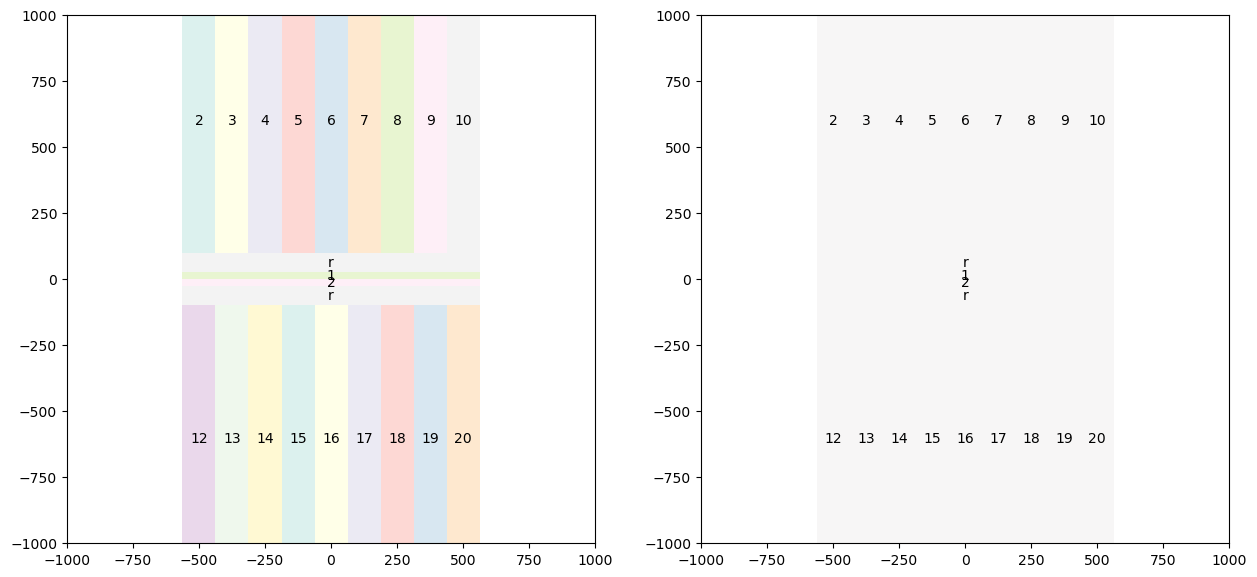

In [5]:
spacing = 5.
n = 9
dc_width = 120.
# dc_height = 1000.
dc_height = 1000.
dc_mid_height = 20.
dc_mid_width = n * dc_width + (n-1) * spacing
rf_height = 70.
rf_width = n * dc_width + (n-1) * spacing
dc_start_pos = [(-(4.5*dc_width + 4*spacing), (2.5*spacing + dc_mid_height + rf_height)),
               (-(4.5*dc_width + 4*spacing), -(2.5*spacing + dc_mid_height + rf_height + dc_height))]
rf_start_pos = [(-(4.5*dc_width + 4*spacing), (1.5*spacing + dc_mid_height)),
               (-(4.5*dc_width + 4*spacing), -(1.5*spacing + dc_mid_height + rf_height))]
dc_mid_start_pos = [(-(4.5*dc_width + 4*spacing), (.5*spacing)),
                   (-(4.5*dc_width + 4*spacing), -(.5*spacing +dc_mid_height))]

s = trap(spacing, dc_width, dc_height, dc_start_pos,
         rf_width, rf_height, rf_start_pos,
         dc_mid_width, dc_mid_height, dc_mid_start_pos,
         n, r=2)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
s.plot(ax[0])
s.plot_voltages(ax[1], u=s.rfs)

r= 1000
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

In [31]:
# s['2'].dc = 1
x_b = (-750, 750)
y_b = (-750, 750)
z_b = (0, 150)
z = 50 # height of ion above metal
gr = 50

def make_xy_grid_flat(x_grid_bounds, y_grid_bounds, z, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res)
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res)
    grid = []
    for y in ts_y:
        for x in ts_x:
            grid.append([x, y, z])
    return grid, ts_x, ts_y

def make_xyz_grid_flat(x_grid_bounds, y_grid_bounds, z_grid_bounds, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res)
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res)
    ts_z = np.linspace(z_grid_bounds[0], z_grid_bounds[1], grid_res)
    grid = []
    for z in ts_z:
        for y in ts_y:
            for x in ts_x:
                grid.append([x, y, z])
    return grid, ts_x, ts_y, ts_z


xy, tsx, tsy = make_xy_grid_flat(x_b, y_b, z, grid_res=gr)

In [34]:
pot = s.individual_potential(xy, 0)

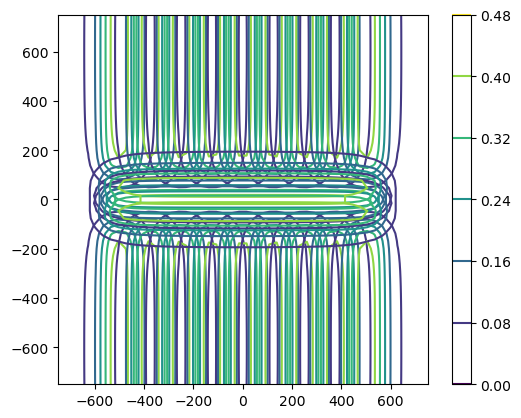

In [69]:
# fig1, ax1 = plt.subplots()
plt.gca().set_aspect('equal')
for i in range(len(s.names)):
    xy_only = np.delete(np.array(xy),2,1)
    x = xy_only[:, 0]
    y = xy_only[:, 1]
    potential = np.reshape(pot[i], (50,50))
    cf = plt.contour(tsx, tsy, potential, 5)
plt.colorbar(cf)

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_88570/421714713.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


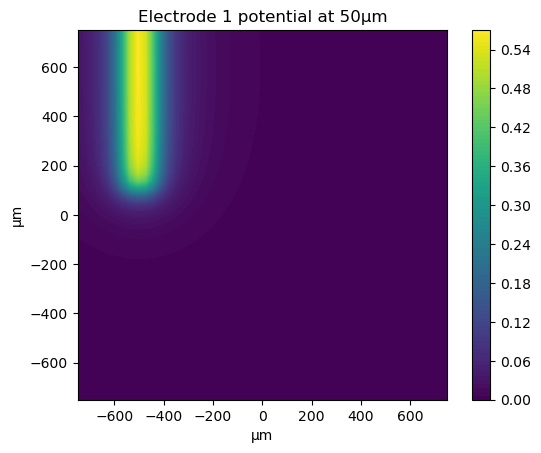

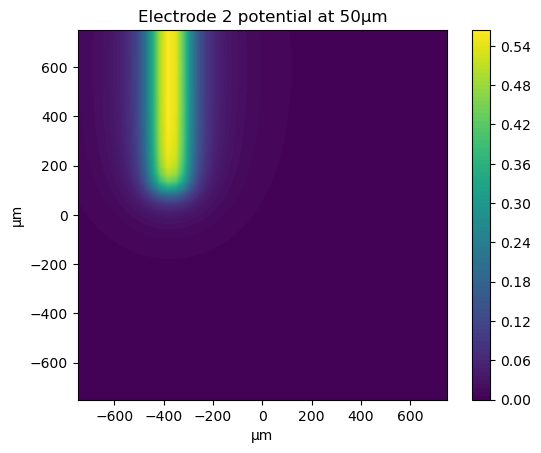

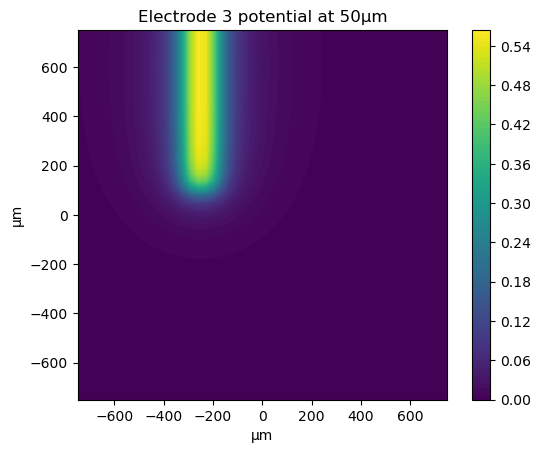

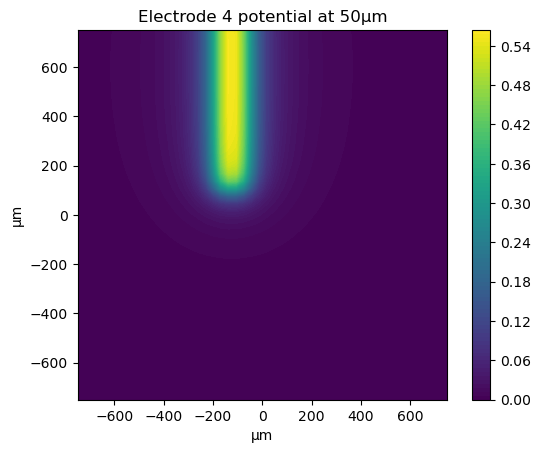

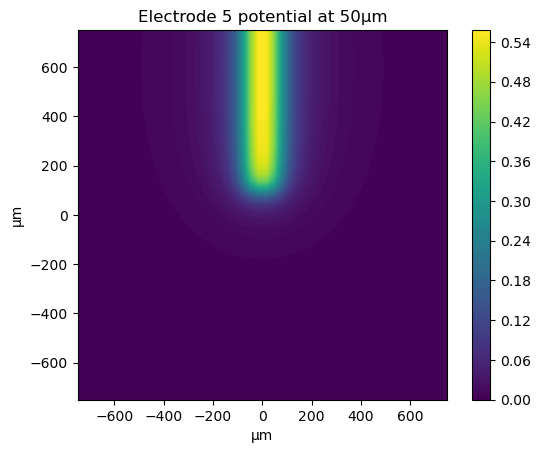

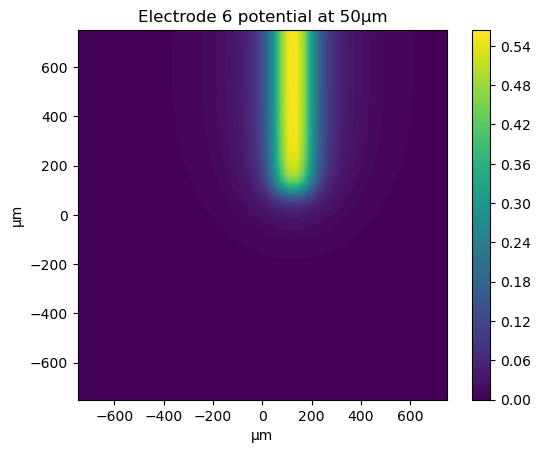

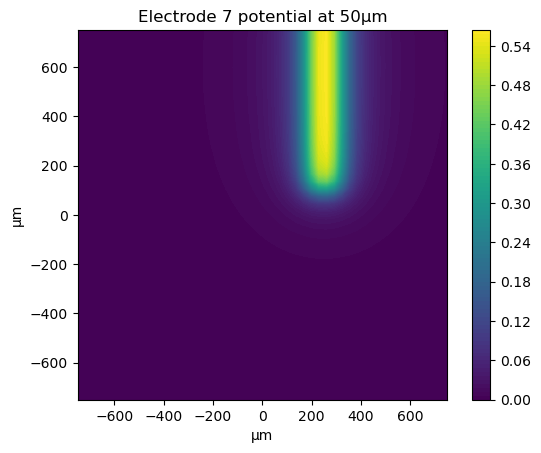

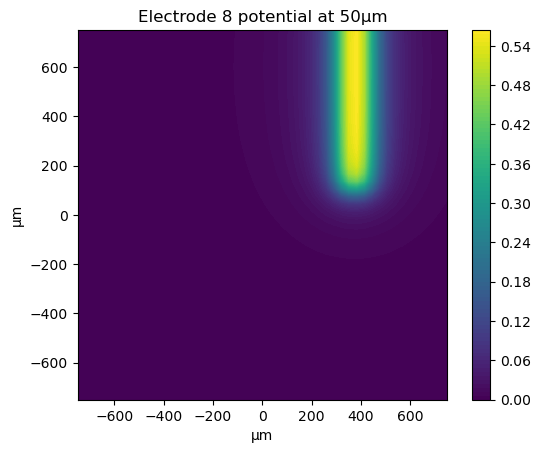

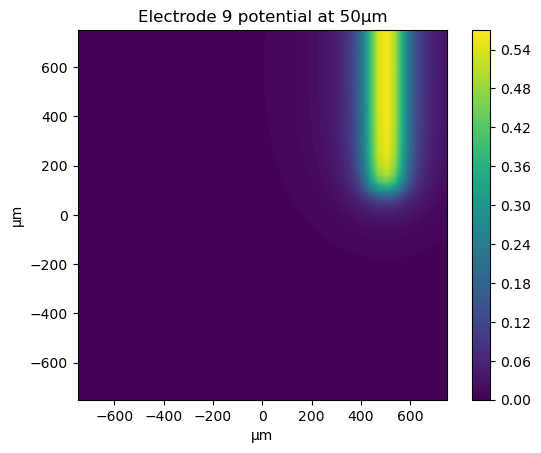

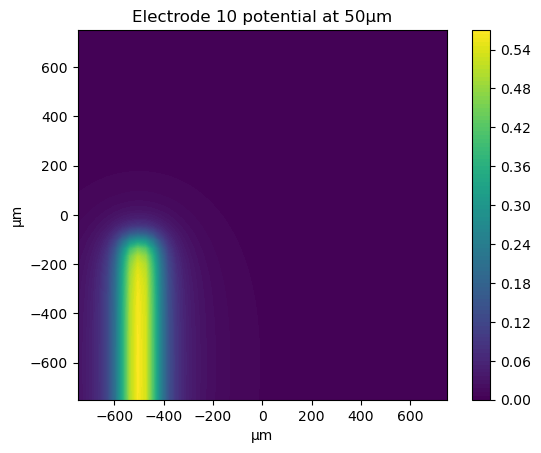

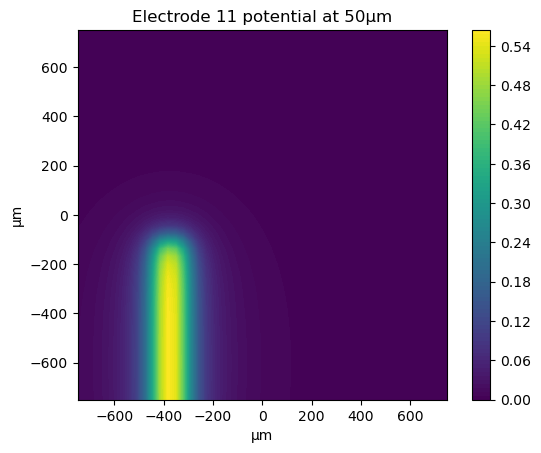

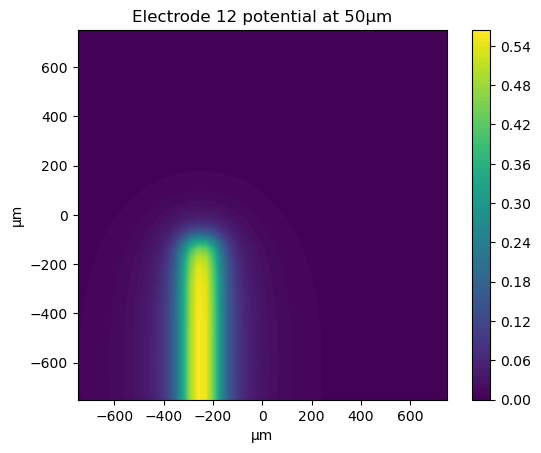

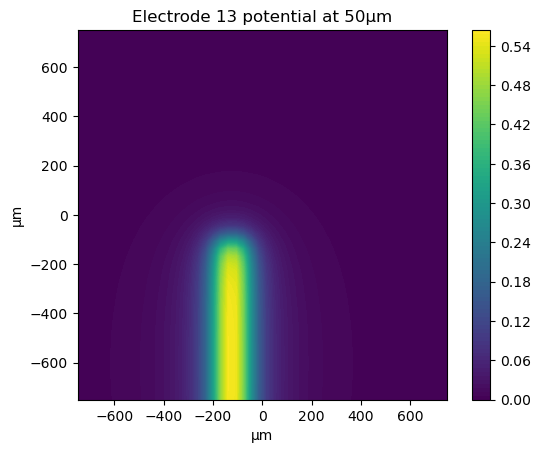

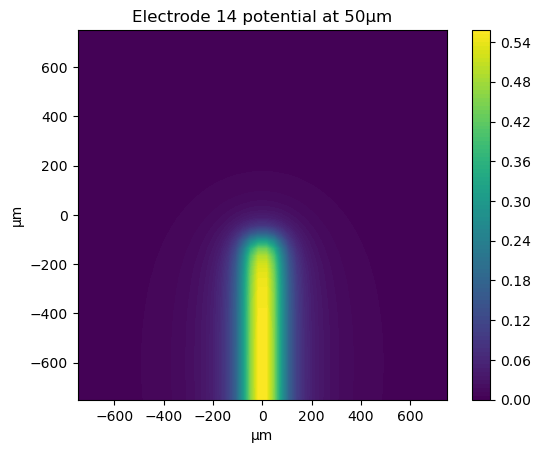

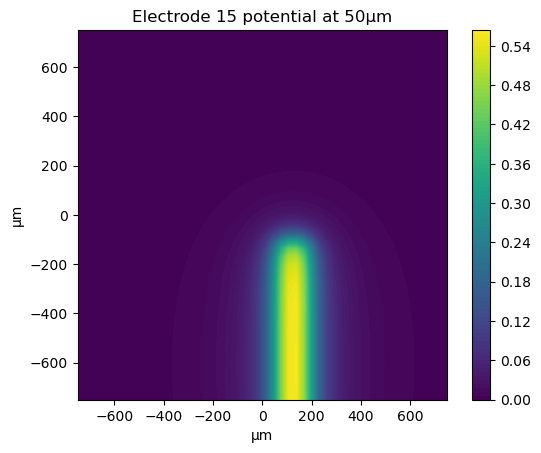

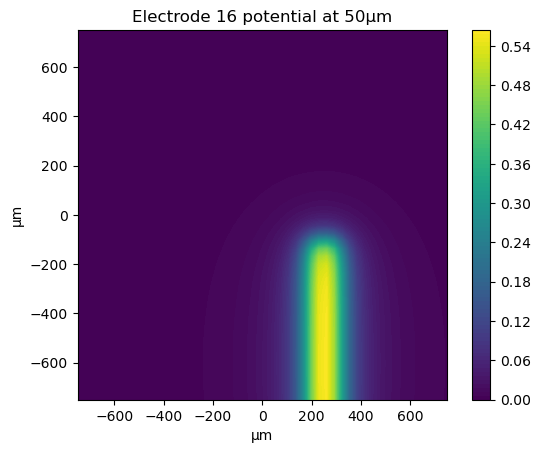

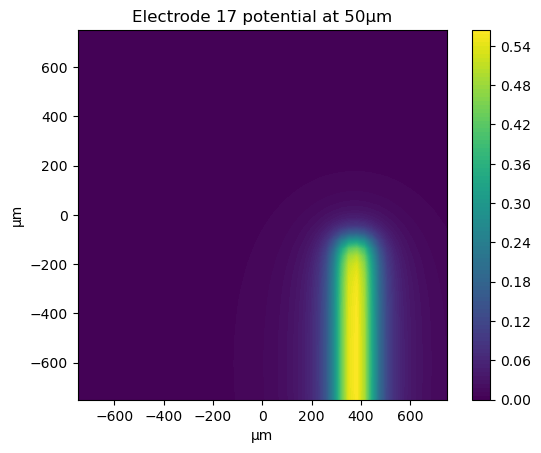

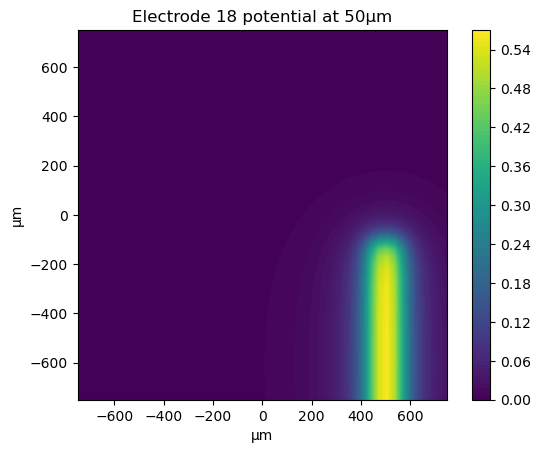

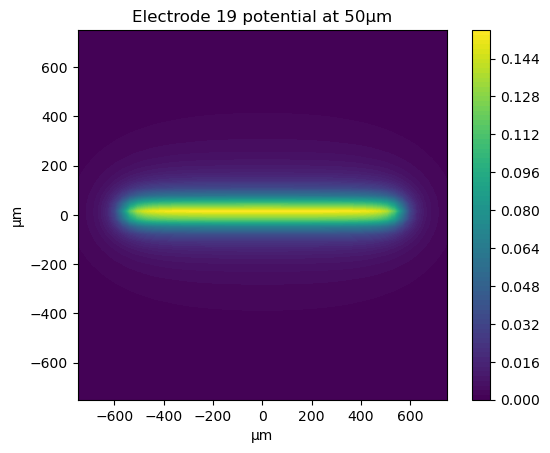

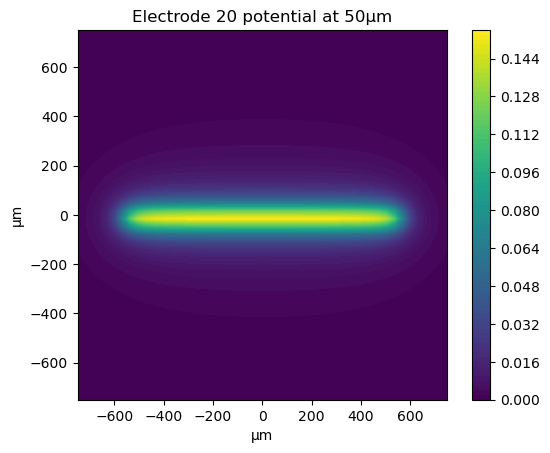

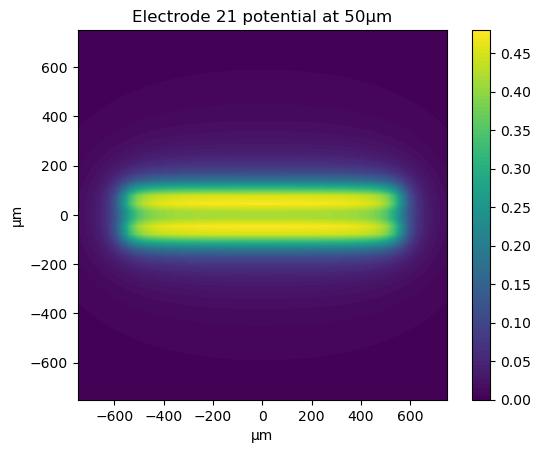

In [71]:
# potentials : array, shape (m, n, l)
#             Potential contributions. `m` is the electrode index (index
#             into `self`). `n` is the point index, `l = 2 * derivative +
#             1` is the derivative index.
for i in range(len(s.names)):
    xy_only = np.delete(np.array(xy),2,1)
    x = xy_only[:, 0]
    y = xy_only[:, 1]
    potential = np.reshape(pot[i], (50,50))
    fig1, ax1 = plt.subplots()
    ax1.set_aspect('equal')
    ax1.set_title(f'Electrode {i+1} potential at 50µm')
    ax1.set_xlabel('µm')
    ax1.set_ylabel('µm')
    cf = ax1.contourf(tsx, tsy, potential, 100)
    fig1.colorbar(cf)

In [76]:
s1 = System([e for e in s if not e.rf])
derivs = "y z xx xy xz yy yzz".split()
x0 = np.array([0, 0, 0.1])
u = s1.shims([(x0 + 1e-3, None, deriv) for deriv in derivs])
fig, ax = plt.subplots(3, len(derivs)//2, figsize=(14, 14))
for d, ui, axi in zip(derivs, u, ax.flat):
    with s1.with_voltages(dcs=ui):
        s.plot_voltages(axi)
        axi.set_aspect("equal")
        axi.set_xlim(-r, r)
        axi.set_ylim(-r, r)
        um = ui[np.argmax(np.fabs(ui))]
        axi.set_title("%s, max=%g" % (d, um))

ValueError: solve failed: unknown

In [28]:
l = 1e-6 # µm length scale
u = 20. # V rf peak voltage
m = 40*ct.atomic_mass # Ca ion mass
q = 1*ct.elementary_charge # ion charge
o = 2*np.pi*30e6 # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

x0 = s.minimum((0, 0, 1.), axis=(1, 2))

for line in s.analyze_static(x0, axis=(1, 2), m=m, q=-q, l=l, o=o):
    print(line)

ValueError: failed, 0, Warning: Desired error not necessarily achieved due to precision loss.,  message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 1.7450189096682622
       x: [ 2.624e+00 -2.751e+00]
     nit: 3
     jac: [-5.680e-03 -1.412e-02]
    nfev: 82
    njev: 75
    nhev: 4